In [1]:
import os
import pandas as pd
import numpy as np
import time
import cv2
import tensorflow as tf
import keras.backend as K
import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
##from tensorflow.keras.utils import multi_gpu_model

from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from keras.layers import Activation, Dense
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6023352335794323552
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3665166336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3282896653846268169
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


# Data Preprocessing

We first must analyze our dataset and understand the characteristics of the data we wish to understand.

In [3]:
data_path="dataset/"
data=pd.read_csv(data_path+"label.csv")
file_names=list(data['file_name'])
labels=data['label'].values.reshape(-1,1)

In [4]:
labels

array([['meningioma_tumor'],
       ['no_tumor'],
       ['meningioma_tumor'],
       ...,
       ['glioma_tumor'],
       ['glioma_tumor'],
       ['pituitary_tumor']], dtype=object)

In [5]:
data.label.unique()

array(['meningioma_tumor', 'no_tumor', 'glioma_tumor', 'pituitary_tumor'],
      dtype=object)

In [6]:
len(data.label.unique())

4

It is evident that the data involves 4 label/categories that describe the classes present in the dataset, which determines the number of categories that our model should model around. However, we must remember to encode our labels into numerical values so they are usable for our models. Here I label the 4 unique tumor labels with one-hot encoding to create 4 distinct columns to represent each label. Below us the process of encoding each label in our dataset from a string category to numerical category, as well as the encode mapping.

In [7]:
ohe = OneHotEncoder(handle_unknown = "ignore", sparse=False)
ohe_labels = ohe.fit_transform(labels)

In [8]:
data

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor
...,...,...
2995,IMAGE_2995.jpg,no_tumor
2996,IMAGE_2996.jpg,meningioma_tumor
2997,IMAGE_2997.jpg,glioma_tumor
2998,IMAGE_2998.jpg,glioma_tumor


In [9]:
ohe_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

Next, we will assign each of the image files in our dataset with the corresponding label described in the csv file. Also, we will be resizing each image to a fixed resolution so that our model will learn on a single resolution. This also helps in some cases where the input image is too large, and thus we lower the processing power needed for our model.

In [10]:
dataset_tumor=[]

for file_index in range(len(file_names)):
    file=cv2.imread(data_path+"/image/"+file_names[file_index])
    file_resize=cv2.resize(file,(128,128))/255.
    dataset_tumor.append(file_resize)

Following this, we split our dataset for training and testing. The size we split on is 80:20 for training against testing. Random state parameter is used to randomize the initial point of splitting, to add extra randomization to the process.

# Training and Validation

In [11]:
tumor_data = np.array(dataset_tumor)
x_train,x_test,y_train,y_test=train_test_split(tumor_data,ohe_labels,test_size=0.2,random_state=25) 

In [12]:
x_train.shape

(2400, 128, 128, 3)

In [13]:
y_train.shape

(2400, 4)

Here we define our model. For the task A1, we will be using the deep learning model CNN or convolutional neural network.

In [14]:

initial_layer=keras.Input(shape=(128,128,3),name="image")

x1=layers.Conv2D(64,(22,22),strides=2)(initial_layer)
x1=layers.MaxPooling2D((4,4))(x1)
x1=layers.BatchNormalization()(x1)

x2=layers.Conv2D(128,(11,11),strides=2,padding="same")(x1)
x2=layers.MaxPooling2D((2,2))(x2)
x2=layers.BatchNormalization()(x2)

x3=layers.Conv2D(256,(7,7),strides=2,padding="same")(x2)
x3=layers.MaxPooling2D((2,2))(x3)
x3=layers.BatchNormalization()(x3)

x4=layers.Flatten()(x3)
x4=layers.Activation("relu")(x4)

x5=layers.Dense(1024,"relu")(x4)

x6=layers.Dense(256,"relu")(x5)

xfinal=layers.Dense(4)(x6)
pred=layers.Activation("softmax")(xfinal)

model=keras.Model(inputs=initial_layer,outputs=pred)

model.compile(loss="categorical_crossentropy",optimizer="sgd",  metrics=['mae', 'categorical_accuracy'])
model.fit(x_train,y_train,epochs=20,batch_size=32,shuffle=False)


Epoch 1/20
75/75 [==============================] - 6s 15ms/step - loss: 0.8973 - mae: 0.2625 - categorical_accuracy: 0.6442
Epoch 2/20
75/75 [==============================] - 1s 14ms/step - loss: 0.5300 - mae: 0.1720 - categorical_accuracy: 0.8221
Epoch 3/20
75/75 [==============================] - 1s 14ms/step - loss: 0.2859 - mae: 0.1024 - categorical_accuracy: 0.9312
Epoch 4/20
75/75 [==============================] - 1s 14ms/step - loss: 0.1250 - mae: 0.0495 - categorical_accuracy: 0.9812
Epoch 5/20
75/75 [==============================] - 1s 14ms/step - loss: 0.0519 - mae: 0.0228 - categorical_accuracy: 0.9975
Epoch 6/20
75/75 [==============================] - 1s 14ms/step - loss: 0.0245 - mae: 0.0111 - categorical_accuracy: 0.9992
Epoch 7/20
75/75 [==============================] - 1s 14ms/step - loss: 0.0145 - mae: 0.0067 - categorical_accuracy: 0.9992
Epoch 8/20
75/75 [==============================] - 1s 14ms/step - loss: 0.0100 - mae: 0.0047 - categorical_accuracy: 0.9996


Usually here we assess the quality of the model based on the loss performance, if it is still unsatisfactory, we repeat with different hyperparameters until we arrive at an acceptable performance. After that, we can test our model on the leftover testing data we split earlier. This showcases our model's  ability to predict on unknown data.

# Testing

In [15]:
result=model.predict(x_test)
print(result)

[[9.98273015e-01 1.51112746e-03 1.13359638e-04 1.02483515e-04]
 [6.68432564e-04 2.35902565e-03 1.08527637e-03 9.95887220e-01]
 [1.50529280e-01 1.55029789e-01 6.92071676e-01 2.36927648e-03]
 ...
 [6.85666621e-01 3.13572109e-01 5.23258583e-04 2.37985369e-04]
 [9.95464265e-01 3.89168388e-03 5.29768353e-04 1.14282353e-04]
 [2.74026988e-05 9.00004088e-05 9.99880195e-01 2.40796385e-06]]


In [16]:
result.shape

(600, 4)

In [17]:
result_eval = model.evaluate(x_test,y_test)
result_eval

19/19 [==============================] - 0s 8ms/step - loss: 0.3019 - mae: 0.0492 - categorical_accuracy: 0.9200


[0.3018988072872162, 0.049152079969644547, 0.9200000166893005]

Here after the softmax level, we need to obtain the single class that each input data corresponds to (according to the model), so we utilize argmax to determine the predicted class, which we will then compare to the original class.

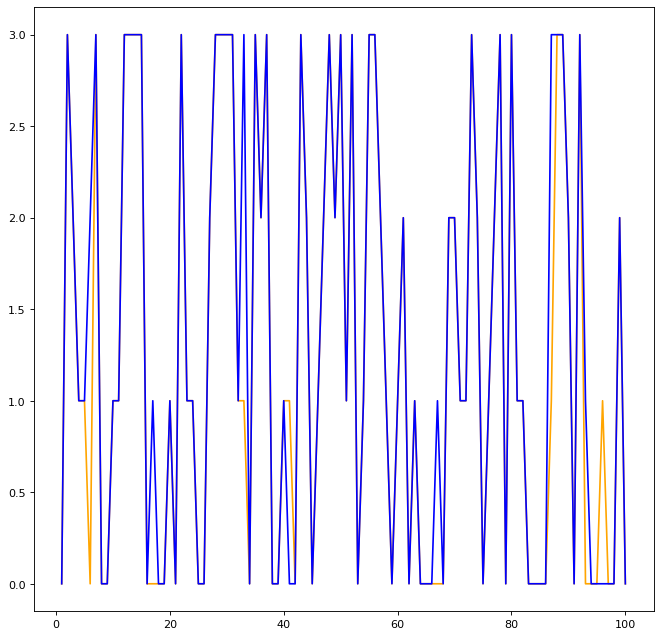

In [18]:
result_class = np.argmax(result, axis=1)
y_test_class = np.argmax(y_test, axis=1)
epochs=range(1,101)


#Continuous figure
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(epochs,y_test_class[:100],'r',label='real',color='orange')
plt.plot(epochs,result_class[:100],'b',label='pred',color='blue')

"""
#Discrete figure
fig = plt.figure(figsize=(10, 10), dpi=100)
ax1 = fig.add_subplot(111)
ax1.scatter(epochs,y_test_class[:100], s=10, c='b', marker="s", label='fig 1')
ax1.scatter(epochs,result_class[:100], s=10, c='r', marker="o", label='fig 2')
plt.legend(loc='upper left');
"""
plt.show()

In [19]:
acc = sklearn.metrics.accuracy_score(result_class, 
                                     y_test_class)
acc

0.92